In [1]:
using Revise


using LinearAlgebra, QuadGK, Roots, FFTW, FastGaussQuadrature
using VlasovSolvers
import VlasovSolvers: advection!
import VlasovSolvers: samples, Particles, PIC_step!, ParticleMover, kernel_poisson!, kernel_gyrokinetic!
using ProgressMeter
using Plots
# pgfplotsx()


using LaTeXStrings

# Quadrature rules

In [2]:
struct RectangleRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function RectangleRule(len, start, stop)
        points = LinRange(start, stop, len+1)[1:end-1]
        s = step(points) 
        weights = [s for _ = 1:len]
        new(len, start, stop, vec(points), weights, s)
    end
end

In [3]:
struct TrapezoidalRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function TrapezoidalRule(len, start, stop)
        points = LinRange(start, stop, len)[1:end]
        s = step(points) 
        weights = [s for _ = 1:len]
        weights[1] /= 2
        weights[end] /= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [4]:
struct SimpsonRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function SimpsonRule(len, start, stop)
        # make sure the number of points is uneven
        if len % 2 == 0
            len += 1
        end
        points = LinRange(start, stop, len)
        s = step(points) 
        weights = s/3 .* ones(len)
        weights[2:2:end-1] .*= 4
        weights[3:2:end-2] .*= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [5]:
struct GaussHermiteRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussHermiteRule(len, start, stop)
        points, weights = gausshermite(len)
        weights .*= exp.(points.^2)
        new(len, start, stop, points, weights)
    end
end

In [6]:
struct GaussLegendreRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLegendreRule(len, start, stop)
        points, weights = gausslegendre(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [7]:
struct GaussRadauRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussRadauRule(len, start, stop)
        points, weights = gaussradau(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [8]:
struct GaussLobattoRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLobattoRule(len, start, stop)
        points, weights = gausslobatto(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [9]:
struct KronrodRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function KronrodRule(len, start, stop)
        pts, w, _ = kronrod(len)
        weights = []
        points = []
        for i = 1:len
            push!(points, pts[i])
            push!(weights, w[i])
            push!(points, -pts[i])
            push!(weights, w[i])
        end
        push!(points, pts[end])
        push!(weights, w[end])
        
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        len = 2*len + 1
        new(len, start, stop, points, weights)
end
    end

In [10]:
# Only works for rectangle and trapezoidal rules
function projection_onto_grid!(grid_dst, meshx, meshv, X, V_, W)
    meshxstep = meshx[2] - meshx[1]
    meshvstep = meshv[2] - meshv[1]
    grid_dst .= 0


    # Periodic Boundary conditions on velocity
    V = copy(V_)
    V[findall(v -> v >= meshv[end],  V)] .-= meshv[end] - meshv[1]
    V[findall(v -> v < meshv[1],  V)] .+= meshv[end] - meshv[1]
    
    for ipart = 1:length(X)
        idxgridx = Int64(fld(X[ipart],            meshxstep)) + 1
        idxgridv = Int64(fld(V[ipart] - meshv[1], meshvstep)) + 1
        idxgridxp1 = idxgridx<length(meshx) ? idxgridx+1 : 1
        idxgridvp1 = idxgridv<length(meshv) ? idxgridv+1 : 1
        
        tx = (X[ipart]             - (idxgridx-1) * meshxstep) / meshxstep
        tv = (V[ipart] - meshv[1]  - (idxgridv-1) * meshvstep) / meshvstep

        # println((idxgridv, V[ipart]))
        grid_dst[idxgridx  , idxgridv  ] += W[ipart] * (1-tx) * (1-tv)
        grid_dst[idxgridx  , idxgridvp1] += W[ipart] * (1-tx) * tv
        grid_dst[idxgridxp1, idxgridvp1] += W[ipart] * tx     * tv
        grid_dst[idxgridxp1, idxgridv  ] += W[ipart] * tx     * (1 - tv)
    end
end

projection_onto_grid! (generic function with 1 method)

# Numerical examples

In [159]:
struct LandauDamping
    α
    kx
    μ
    β
    f0
    shortname
    L 
    vmin 
    vmax

    function LandauDamping(alpha, kx, mu, beta; 
                            shortname="(Strong/Weak) Landau damping", L=nothing, vmin=-9, vmax=9)
        if L == nothing 
            L = 2π / kx 
        end
        f(x,v) = (1 + alpha * cos(kx*x)) * exp(- beta * (v-mu)^2 / 2) / √(2π/beta)
        new(alpha, kx, mu, beta, f, shortname, L, vmin, vmax)
    end
end


struct TwoStreamInstability 
    α
    kx
    μ
    β
    f0
    shortname
    L 
    vmin 
    vmax

    function TwoStreamInstability(alpha, kx, mu, beta; 
                                    shortname="Two-Stream Instability", L=nothing, vmin=-9, vmax=9)
        if L == nothing 
            L = 2π / kx 
        end
        f(x,v) = (1 - alpha * cos(kx*x)) * v^2 * exp(- beta * (v-mu)^2 / 2) / √(2π/beta)
        new(alpha, kx, mu, beta, f, shortname, L, vmin, vmax)
    end
end


struct BumpOnTail 
    α
    kx
    μ₁
    μ₂
    β₁
    β₂
    n₁
    n₂
    f0
    shortname
    L 
    vmin 
    vmax

    function BumpOnTail(alpha, kx, mu1, mu2, beta1, beta2; 
                        n1=0.9, n2=0.2, shortname="Bump on Tail", L=nothing, vmin=-9, vmax=9)
        if L == nothing 
            L = 2π / kx 
        end
        f(x,v) = (1 + alpha * cos(kx*x)) * ((n1 *exp(-beta1*(v-mu1)^2 /2) + n2*exp(-beta2*(v-mu2)^2 / 2)) / √(2π))
        new(alpha, kx, mu1, mu2, beta1, beta2, n1, n2, f, shortname, L, vmin, vmax)
    end
end


example_landaudamping = LandauDamping(0.001, 0.5, 0., 1.; shortname="Weak Landau damping");
example_stronglandaudamping = LandauDamping(0.5, 0.5, 0., 1.; shortname="Strong Landau damping");
example_twostreaminstability = TwoStreamInstability(0.05, 0.2, 0., 1.);
example_bumpontail = BumpOnTail(0.04, 0.3, 0, 4.5, 1, 4);

# SL classique

In [160]:
"""
    hmf_poisson!(fᵗ    :: Array{Complex{Float64},2},
                 mesh1 :: OneDGrid,
                 mesh2 :: OneDGrid,
                 ex    :: Array{Float64})

    Compute the electric hamiltonian mean field from the
    transposed distribution function

"""
function hmf_poisson!(fᵗ::Array{Complex{Float64},2},
        mesh1::OneDGrid,
        mesh2::OneDGrid,
        ex::Array{Float64}; K=1)

    n1 = mesh1.len
    rho = mesh2.step .* vec(sum(fᵗ, dims=1)) # ≈ ∫ f(t,x_i,v)dv, i=1, ..., n1
    kernel = zeros(Float64, n1)
    ker = -(mesh1.stop - mesh1.start) / (2π)
    for k=1:K
        kernel[1+k]   =  ker / k    # fourier mode  1
        kernel[end - (k-1)] = -ker / k    # fourier mode -1
    end
    ex .= real(ifft(fft(rho) .* 1im .* kernel))
end

function solve_SL!(nsteps, dt, f, mesh1, mesh2, kx; plotting=false::Bool)
    n1, n2 = size(f)
    fᵗ = zeros(Complex{Float64}, (n2,n1))
    transpose!(fᵗ, f)

    energy² = Array{Float64}(undef, nsteps)
    etot² = Array{Float64}(undef, nsteps)
    momentum = Array{Float64}(undef, nsteps)

    ex = zeros(Float64, n1)
    hmf_poisson!(fᵗ, mesh1, mesh2, ex)
    advection!(fᵗ, mesh2, ex, 0.5dt)

    progression = ProgressMeter.Progress(nsteps,desc="Loop in time: ", showspeed=true)
    
    animation = @animate for istep = 1:nsteps
        energy²[istep] = sum(ex.^2) * mesh1.step
        etot²[istep] = (energy²[istep] + sum(mesh2.points'.^2 .* real(f)) * mesh1.step * mesh2.step) / 2
        momentum[istep] = sum(sum(real(f), dims=1) .* mesh2.points) * mesh1.step * mesh2.step
    
        advection!(f, mesh1, mesh2.points, dt)
        transpose!(fᵗ, f)
        hmf_poisson!(fᵗ, mesh1, mesh2, ex)
        advection!(fᵗ, mesh2, ex, dt)
        transpose!(f, fᵗ) 
        
        if plotting
            plot(mesh1.points, mesh2.points, real(f)', size=(500, 500), st=:surface, camera=(0, 90))
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        
        ProgressMeter.next!(progression)
    end when plotting
    if plotting
        return sqrt.(energy²), sqrt.(etot²), momentum, ex, animation
    else
        return sqrt.(energy²), sqrt.(etot²), momentum, ex, nothing
    end
end

solve_SL! (generic function with 1 method)

# PIC solver

In [161]:
function solve_PIC!(nsteps, dt, particles, meshx; kx=0, plotting=false::Bool, kernel=kernel_poisson!)
    energy_elec² = Array{Float64}(undef, nsteps)
    energy_tot²= Array{Float64}(undef, nsteps)
    momentum = Array{Float64}(undef, nsteps)

    L = meshx.stop
    np = particles.nbpart

    pmover = ParticleMover(particles, meshx, 1, dt; kx)

    if plotting
        widthx = -(-)(extrema(quadrulex.points)...)
        widthv = -(-)(extrema(quadrulev.points)...)
        scale = 0.7
    end
    
    progression = ProgressMeter.Progress(nsteps, desc="Loop in time: ", showspeed=true)
    animation = @animate for istep = 1:nsteps
        if plotting
            # plot(vec(p.x), vec(p.v), vec(p.wei), seriestype=:scatter, markersize=sqrt(widthx * widthv * scale^2  / (nx*nv) / π), camera=(0, 90), markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=vec(p.wei), c=:rainbow,aspect_ratio=:equal, size=(widthx, widthv).*scale)
            plot(vec(p.x), vec(p.v), vec(p.wei), seriestype=:scatter, markersize=sqrt(600*600 / (nx*nv) / π) * scale, camera=(0, 90), markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=vec(p.wei), c=:rainbow,aspect_ratio=:equal, size=(600, 600))
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end

        eelec², mom, etot² = PIC_step!(p, pmover; kernel=kernel)
        energy_elec²[istep] = eelec²
        momentum[istep] = mom
        energy_tot²[istep] = etot² 
        
        ProgressMeter.next!(progression)
    end when plotting
    if !plotting
        animation = nothing
    end
    return sqrt.(energy_elec²), momentum, sqrt.(energy_tot²), animation
end

solve_PIC! (generic function with 1 method)

# Inputs indépendants du cas test

In [162]:
dev = CPU()

example = example_twostreaminstability

nstep = 1000
dt = 0.1

nx = 128
nv = 129

meshx = OneDGrid(dev, nx, 0, example.L);
meshv = OneDGrid(dev, nv, example.vmin, example.vmax);

quadX = TrapezoidalRule
quadV = TrapezoidalRule

quadrulex = quadX(nx, 0, example.L);
quadrulev = quadV(nv, example.vmin, example.vmax);
# quadrulev = quadV(nv, μ - 5/√β, μ + 5/√β)


T = NaN;

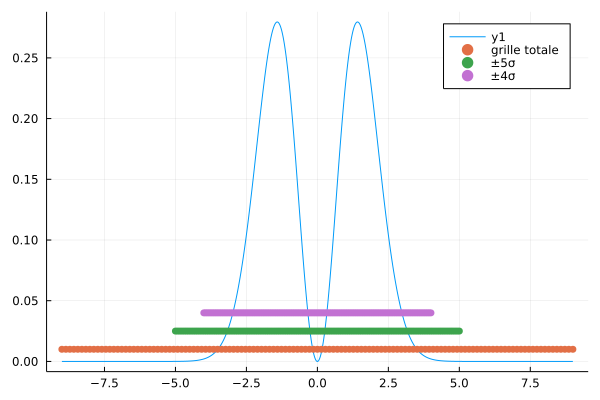

In [163]:
gridv = example.vmin:0.01:example.vmax

ex_quadrulev = quadV(nv, example.vmin, example.vmax);
ex_quadrulev2 = quadV(nv, example.μ - 5/√example.β, example.μ + 5/√example.β)
ex_quadrulev3 = quadV(nv, example.μ - 4/√example.β, example.μ + 4/√example.β)

plot(gridv, example.f0.(π/2, gridv))
plot!(ex_quadrulev.points, zeros(ex_quadrulev.len) .+ 0.01, seriestype=:scatter, markerstrokewidth=0, label="grille totale")
plot!(ex_quadrulev2.points, zeros(ex_quadrulev2.len) .+ 0.025, seriestype=:scatter, markerstrokewidth=0, label="±5σ")
plot!(ex_quadrulev3.points, zeros(ex_quadrulev3.len) .+ 0.040, seriestype=:scatter, markerstrokewidth=0, label="±4σ")

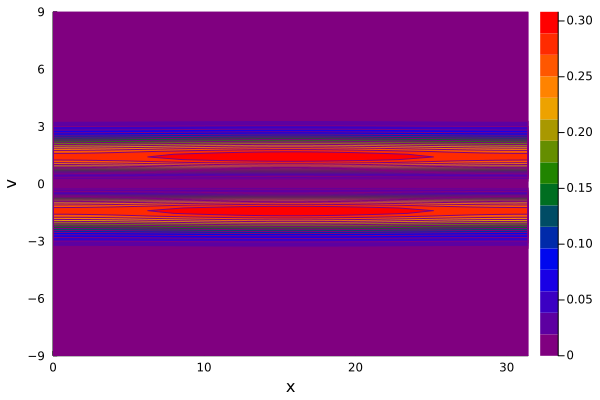

In [164]:
# plot(quadrulex.points, quadrulev.points', f.(quadrulex.points, quadrulev.points')', st=:surface, camera=(80, 30))
contourf(quadrulex.points, quadrulev.points, vec(example.f0.(quadrulex.points, quadrulev.points')), c=:rainbow)
xlabel!("x")
ylabel!("v")
# savefig("gif/gyrokinetic_example.png")

# Simulations

In [165]:
gsl = zeros(Complex{Float64}, (nx,nv));
@. gsl = example.f0.(meshx.points, meshv.points');
@time E_elecsl, E_totsl, momentumsl, _, animationsl = solve_SL!(nstep, dt, gsl, meshx, meshv, example.kx; plotting=false);

Loop in time: 100%|███████████████████████| Time: 0:00:07 ( 7.55 ms/it)


  7.706084 seconds (19.04 M allocations: 1.648 GiB, 3.17% gc time, 2.02% compilation time)


In [166]:
if animationsl != nothing
    gif(animationcarac, "gif/gyrokinetic_example.mp4");
end

# PIC interpretation

In [167]:
nbparticles = nx*nv
x0 = vec(repeat(quadrulex.points, 1, quadrulev.len)) 
v0 = vec(repeat(quadrulev.points', quadrulex.len, 1))
wei = vec(example.f0.(quadrulex.points, quadrulev.points') .* quadrulex.weights .* quadrulev.weights')
p = Particles(x0, v0, wei, nbparticles);
@time E_eleccarac, momentumcarac, E_totcarac, animationcarac = solve_PIC!(nstep, dt, p, meshx; kx=example.kx, plotting=false, kernel=kernel_poisson!);

Loop in time: 100%|███████████████████████| Time: 0:00:02 ( 2.84 ms/it)


  2.913988 seconds (365.26 k allocations: 2.354 GiB, 9.00% gc time, 2.57% compilation time)


In [168]:
if animationcarac != nothing
    gif(animationcarac, "gif/gyrokinetic_example.mp4");
end

# Classical PIC

In [169]:
# nbparticlespic = Int64(2e5)
# (x0, y0, wei) = samples(np, example.kx, example.α, example.μ, example.β)
# p = Particles(x0, y0, wei, nbparticlespic);
# @time E_elecpic, momentumpic, E_totpic, animation = solve_PIC!(nstep, dt, p, meshx;plotting=false, kx=example.kx);

# Plots

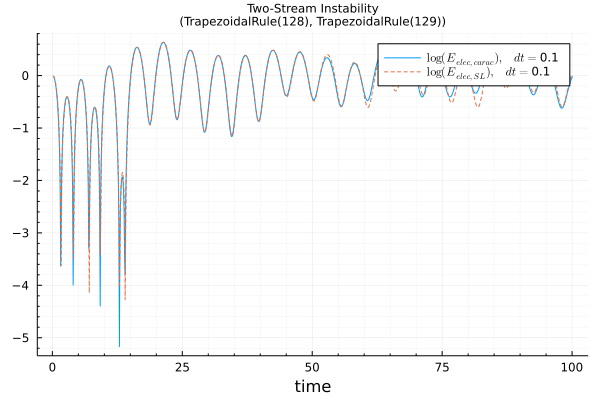

In [170]:
t = (1:nstep) .* dt

# energies
# plot(t .+ dt, E_elecsl, label=L"E_{elec, carac},\quad dt="*"$(dt)", legend=:outertopright, minorgrid=true, size=(400, 200).*2)
# plot!(t .+ dt, E_eleccarac, label=L"\log(E_{elec, carac}),\quad dt="*"$(dt)")



# log(Energies)
plot(legend=:best, minorgrid=true, size=(600, 400))
plot!(t .+ dt, log.(E_eleccarac), label=L"\log(E_{elec, carac}),\quad dt="*"$(dt)")
plot!(t, log.(E_elecsl), label=L"\log(E_{elec, SL}),\quad dt="*"$(dt)", ls=:dash, lw=1)
# plot!(t, log.(E_tot),       label=L"\log(E_{tot}),\quad dt="*"$(dt)")
# plot!(t, log.(E_elecpic), label=L"$\log(E_{elec, PIC}),\quad$ dt="*"$(dt), "* L"$n_p$ ="*"$(nbparticlespic)", ls=:dot)
# plot!(t, log.(energy_from_projection), label=L"\log(E_{pic, PIC}),\quad dt="*"$(dt)")
# plot!(t, log.(energy_elec_from_phi), label=L"\log(E_{from\,\Phi, PIC}),\quad dt="*"$(dt)")


# ============== #

# Landau damping (kx=0.5):
# plot!(x->-0.1533x - 5.6, label="Damping attendu (-0.1533)")
# E_th = abs.(4ϵ * 0.3677 .* exp.(−0.1533 .* t) .* cos.(1.4156.*t .−0.5326245)) * sqrt(L/2)
# plot!(t, log.(E_th),label="Energie theorique")
# Landau damping (kx=0.4):
# plot!(x->-0.0661x - 5.3, label="Damping attendu (-0.0661)")
# E_th = 0.002.*0.42466.*abs.(cos.(1.285.*t .-0.33577)).*exp.(-0.0661.*t) # expression du bouquin, pas correcte
# E_th = abs.(4*ϵ*0.424666*exp.(-0.0661 .* t) .* cos.(1.2850 .* t .- 0.3357725) * sqrt(L/2)) # issue des calculs du bouquin en calculant correctement √(∫sin(0.5x)^2dx)
# plot!(t, log.(E_th),label="Energie theorique", ls=:dashdotdot)

# TSI (k,v0) = (0.2, 1.3):
# plot!(t, -0.001t .- 4.2, label=L"y=0.001t - 5.0")
# TSI (k,v0) = (0.2, 2.4):
# plot!(t, 0.2258t .- 6.4, label=L"y=0.2258t - 8.4")
# TSI (k,v0) = (0.2, 3):
# plot!(t, 0.2845t .- 6.1, label=L"y=0.2845t - 8.2")

# Strong Landau damping
# plot!(t, -0.285473t .+ 1, label=L"y=-0.285473t + 1")
# plot!(t, 0.086671t .- 3.7, label=L"y=0.086671t - 3.7")

title!(example.shortname * "\n($(quadX)($(nx)), $(quadV)($(nv)))", titlefontsize=8)
# xlabel!("t (T=$(T))")
xlabel!("time")

In [171]:
# fn = "methode_carac/test_pgfplots"
# savefig("/Users/ylehenaf/Documents/latex/imgs/tex/$(fn).tikz")

# Plot annotations

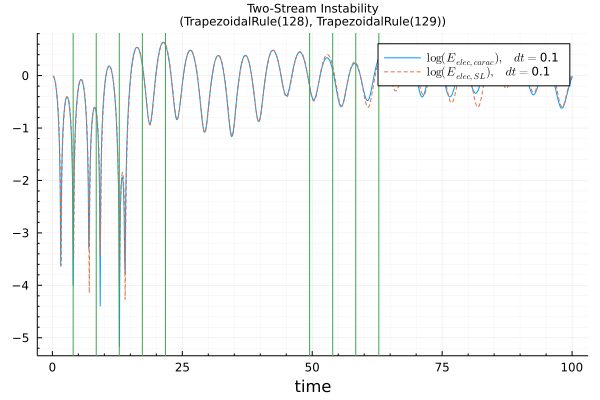

In [172]:
p = 2π / 1.4156
vline!(vcat([4 + i*p for i=0:4], [49.5 + i*p for i=0:3]), label="")
# vline!([28.1 + i*p for i=-4:0], label="")

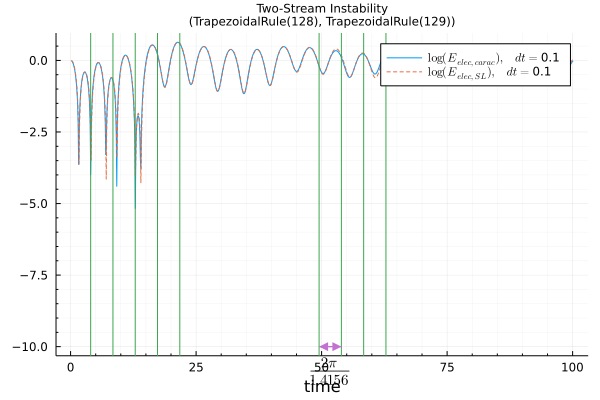

In [173]:
plot!([49.5, 49.5+p], [-10, -10], arrow=arrow(:closed, :both), label="")
annotate!((51.5, -10.3, text(L"\frac{2\pi}{1.4156}", :top, 10)))

# Quantités conservatives (SL Généralisé)

## Variation d'énergie totale

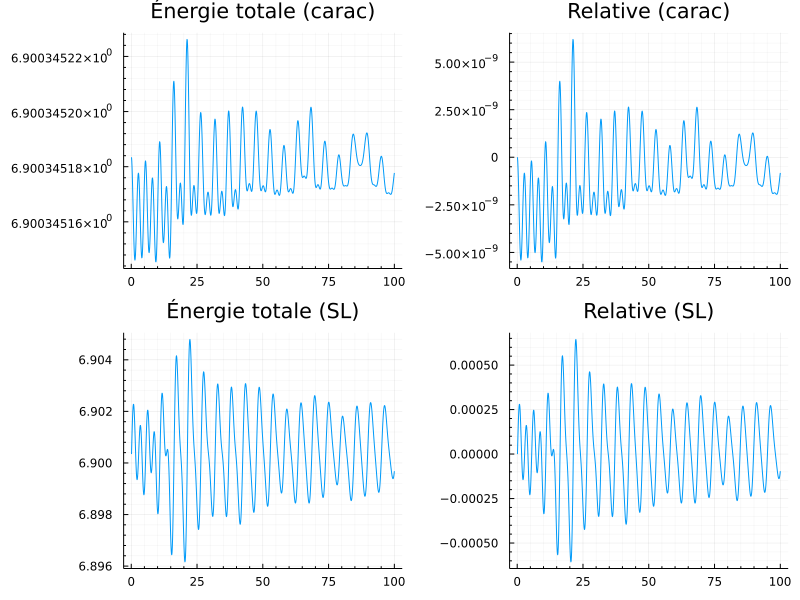

In [174]:
p11 = plot(t, E_totcarac, label="", minorgrid=true)
title!(p11, "Énergie totale (carac)")
p12 = plot(t, (E_totcarac .- E_totcarac[1]) ./ E_totcarac[1], label="", minorgrid=true)
title!(p12, "Relative (carac)")
p21 = plot(t, E_totsl, label="", minorgrid=true)
title!(p21, "Énergie totale (SL)")
p22 = plot(t, (E_totsl .- E_totsl[1]) ./ E_totsl[1], label="", minorgrid=true)
title!(p22, "Relative (SL)")
p=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

In [175]:
p11 = plot(t, E_totpic, label="")
title!(p11, "Énergie totale (PIC)")
p12 = plot(t, (E_totpic .- E_totpic[1]) ./ E_totpic[1], label="")
title!(p12, "Relative (PIC)")
p=plot(p11, p12, size=(800, 600), layout=(2, 1))

LoadError: UndefVarError: E_totpic not defined

## Variations du moment

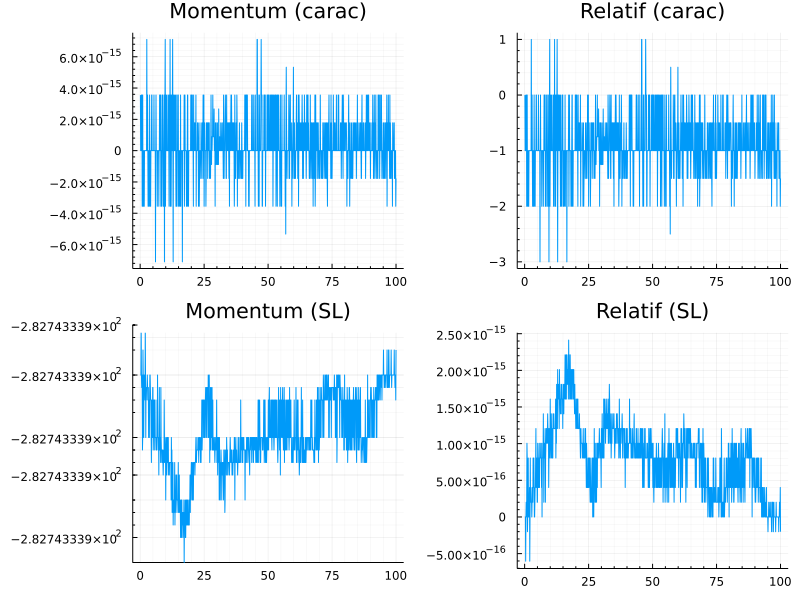

GKS: Possible loss of precision in routine SET_WINDOW


In [176]:
p11 = plot(t, momentumcarac, label="", minorgrid=true)
title!(p11, "Momentum (carac)")
p12 = plot(t, (momentumcarac .- momentumcarac[1]) ./ momentumcarac[1], label="", minorgrid=true)
title!(p12, "Relatif (carac)")
p21 = plot(t, momentumsl, label="", minorgrid=true)
title!(p21, "Momentum (SL)")
p22 = plot(t, (momentumsl .- momentumsl[1]) ./ momentumsl[1], label="", minorgrid=true)
title!(p22, "Relatif (SL)")
p=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

In [177]:
p1 = plot(t, momentumpic, label="", minorgrid=true)
title!(p1, "Momentum (PIC)")
p2 = plot(t, (momentumpic .- momentumpic[1]) ./ momentumpic[1], label="", minorgrid=true)
title!(p2, "Relative (PIC)")
p=plot(p1, p2, size=(800, 600), layout=(2, 1))

LoadError: UndefVarError: momentumpic not defined

# Divers

In [ ]:
ptsX = TrapezoidalRule(32, 0, L);
ptsV = GaussHermiteRule(32, -vmax, vmax);
scatter(repeat(ptsX.points, 1, 32), repeat(ptsV.points', 32, 1), label="")
# for x = ptsX.points, v = ptsV.points
#     sc((x, v))
# end
title!("pts quadrature")

interpolation 2D (NUFFT)

euler 2D

approximation sparse d'une somme (hyperbolic cross)

HMF 4D (2Dx * 2Dv)

Conservation énergie globale après discrétisation du schéma

## Projection onto grid / Interpolation

In [ ]:
E_elec, E_tot, momentum, l2norm, animation, X, V, F = generalized_SL(50, dt, quadrulex, quadrulev, kx, f; plotting=false);

In [ ]:
spline_proj = Dierckx.Spline2D(X, V, vec(f.(quadrulex.points, quadrulev.points')); s=1e-5);
grid_proj = evalgrid(spline_proj, quadrulex.points, quadrulev.points);

In [ ]:
plot(quadrulex.points, quadrulev.points, grid_proj', st=:surface, camera=(0, 90))

## Visualisation des points de quadrature

In [ ]:
fv(v) = f(π/2, v)
plot(fv, -vmax, vmax)
quadrulev1 = quadV(Int(fld(nv, 2)), μ₁ - 5/√β₁, μ₁ + 5/√β₁)
scatter!(quadrulev1.points, zeros(quadrulev1.len) .+ 0.05, strokecolor=0)
quadrulev2 = quadV(Int(fld(nv, 2)), μ₂ - 5/√β₂, μ₂ + 5/√β₂)
scatter!(quadrulev2.points, zeros(quadrulev2.len) .+ 0.1, strokecolor=0)

quadrulevref = quadV(nv, -vmax, vmax)
scatter!(quadrulevref.points, zeros(quadrulevref.len), strokecolor=0)

In [ ]:
abs(sum(fv.(quadrulev.points) .* quadrulev.weights)-1), abs(sum(fv.(newquadrulev.points) .* newquadrulev.weights)-1)

In [ ]:
E_eleccarac